Example of how to use codebase to analyse importance of weights in CNN model zoo

In [33]:
# imports
import torch as th
import numpy as np
import matplotlib.pyplot as plt

# Load Data
We load data from Unterthiner's small CNN model zoo. The metrics are enriched with per class accuracy for every model.

In [72]:
from utils.load_dataset import load_dataset
dataset = 'fashion_mnist'
weights_train, weights_test, outputs_train, outputs_test, configs_train, configs_tes = load_dataset(dataset, metrics_file='metrics_merged.csv', load_class_acc=True)
train_class_accuracies = outputs_train[:, -10:]
test_class_accuracies = outputs_test[:, -10:]

# Get probe/lens model
We train an MLP regressor model to predict per class accuracy. If the regressor is of sufficiently good quality, i.e. it predicts class accuracy with a small enough MSE, we might learn what weights are important for predicitng per class accuracy from studying this probe/lens.

In [22]:
from lenses.regressor_lens import get_regressor_lens
regressor_lens = get_regressor_lens(weights_train, train_class_accuracies, weights_test, test_class_accuracies)

Epoch   1 ─ val MSE 0.029304 | val MAE 0.113616
Epoch   2 ─ val MSE 0.021380 | val MAE 0.091507
Epoch   3 ─ val MSE 0.019259 | val MAE 0.078603
Epoch   4 ─ val MSE 0.018495 | val MAE 0.073634
Epoch   5 ─ val MSE 0.018427 | val MAE 0.073101
Epoch   6 ─ val MSE 0.018312 | val MAE 0.074103
Epoch   7 ─ val MSE 0.017642 | val MAE 0.070582
Epoch   8 ─ val MSE 0.019065 | val MAE 0.074655
Epoch   9 ─ val MSE 0.019468 | val MAE 0.073976
Epoch  10 ─ val MSE 0.017745 | val MAE 0.071782
Epoch  11 ─ val MSE 0.018200 | val MAE 0.073948
Epoch  12 ─ val MSE 0.017777 | val MAE 0.071195
Epoch  13 ─ val MSE 0.018266 | val MAE 0.073813
Epoch  14 ─ val MSE 0.017159 | val MAE 0.070504
Epoch  15 ─ val MSE 0.017166 | val MAE 0.068741
Epoch  16 ─ val MSE 0.016902 | val MAE 0.067084
Epoch  17 ─ val MSE 0.017316 | val MAE 0.067891
Epoch  18 ─ val MSE 0.017832 | val MAE 0.072646
Epoch  19 ─ val MSE 0.017164 | val MAE 0.067682
Epoch  20 ─ val MSE 0.017113 | val MAE 0.068512
Epoch  21 ─ val MSE 0.016834 | val MAE 0

Our regressor lens can make predictions on class accuracy

CNN model index: 16
Label class accuracy for CNN model 16: [0.76  0.88  0.593 0.808 0.659 0.741 0.158 0.822 0.91  0.946]
Predicted class accuracy: [0.7312193  0.9018282  0.6660801  0.7443002  0.5790874  0.75086164
 0.13350464 0.8257709  0.87953305 0.94273406]


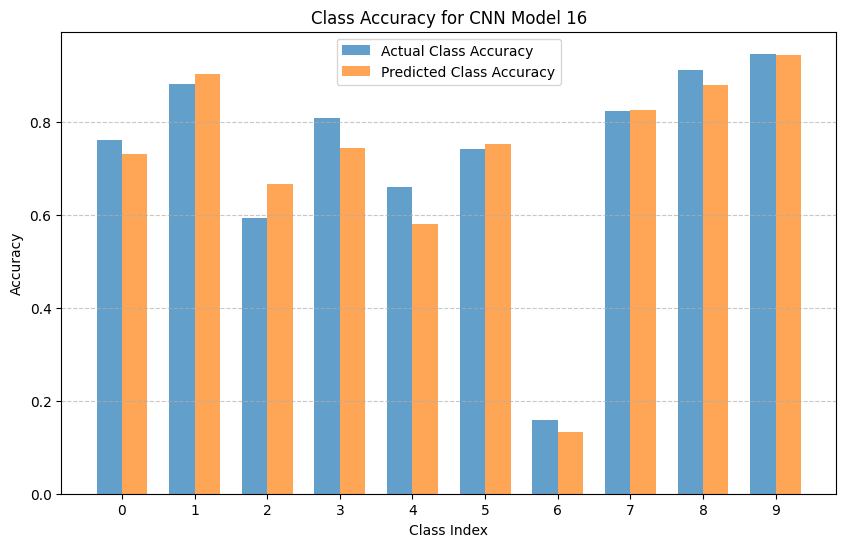

In [52]:
# Define the CNN model index and retrieve its weights and class accuracy
CNN_index = 16  # Example index of a CNN model in the dataset
CNN_weights = weights_train[CNN_index]
CNN_class_accuracy = train_class_accuracies[CNN_index]

# Print model details
print(f"CNN model index: {CNN_index}")
print(f"Label class accuracy for CNN model {CNN_index}: {CNN_class_accuracy}")

# Predict class accuracy using the regressor lens
predicted_class_accuracy = regressor_lens.forward(
    th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0)
).detach().numpy().flatten()
print(f"Predicted class accuracy: {predicted_class_accuracy}")

# Plot the predicted and actual class accuracies as a bar plot
plt.figure(figsize=(10, 6))
width = 0.35  # Width of the bars
x = np.arange(len(CNN_class_accuracy))  # Class indices

# Plot actual class accuracy
plt.bar(x - width / 2, CNN_class_accuracy, width, label="Actual Class Accuracy", alpha=0.7)

# Plot predicted class accuracy
plt.bar(x + width / 2, predicted_class_accuracy, width, label="Predicted Class Accuracy", alpha=0.7)

# Add plot details
plt.title(f"Class Accuracy for CNN Model {CNN_index}")
plt.xlabel("Class Index")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Attribution analysis
By studying the regressor lens, we might learn which CNN weights are important for the regressor to make it's predicition. Let's try an attribution method; Integrated Gradients

In [67]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(regressor_lens)

attributions = {}  # attributions for each class

for class_idx in range(10):
    attributions[class_idx] = ig.attribute(
        th.tensor(CNN_weights, dtype=th.float32).unsqueeze(0),
        target=class_idx,
).flatten().detach().numpy()

Let's plot the results (zoom in and scroll around)

In [75]:
import plotly.graph_objects as go

# Create a grouped bar chart
fig = go.Figure()

for class_idx, class_attributions in attributions.items():
    mean_attributions = class_attributions
    fig.add_trace(go.Bar(
        x=list(range(len(mean_attributions))),
        y=mean_attributions,
        name=f'Class {class_idx}',
        width=0.9,
        opacity=0.7,
    ))

# Add layout details
fig.update_layout(
    title=f'Attributions Across input CNN weights for predicting accuracy for Each Class for {dataset} CNN Model {CNN_index}',
    xaxis_title='Feature Index (Weight Index)',
    yaxis_title='Attribution Value',
    barmode='overlay',  # Align bars for each dataset
    legend_title='Classes'
)

fig.show()